# Stats 701-Homework8 Winter 2018
## Hsuan-Yu Yeh 
### hsuanyu@umich.edu
I discuss with Roger for the algorithm of question 3. For problem 1, I spent 2 hours to finish it. For problem 2, I spent about 3 hours. For problem 3, I spent 3 hours.

## Problem 1: counting words with mrjob

In [96]:
# Q1-1
from mrjob.job import MRJob
import re

WORD_RE = re.compile(r'[\w]+') 
class MRWordFrequencyCount(MRJob):

    def mapper(self, _, line):
        for word in WORD_RE.findall(line):
            yield (word.lower(), 1)
    
    def reducer(self, key, values):
        yield key, sum(values)


if __name__ == '__main__':
    MRWordFrequencyCount.run()

usage: usage: ipykernel_launcher.py [options] [input files]
ipykernel_launcher.py: error: unrecognized arguments: -f


SystemExit: 2

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2918: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


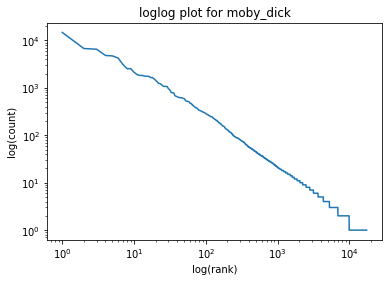

In [28]:
# Q1-4

import os
import matplotlib.pyplot as plt 
import numpy as np

os.chdir('/Users/yehhsuan-yu/Umich/Stats701/hsuanyu_hw9')
f = open('word_counts.txt', 'r')
dat = list()
for line in f:
    inner_list = [elt.strip() for elt in line.split('\t')]
    inner_list[1] = int(inner_list[1])
    dat.append(inner_list)

dat_sort = sorted(dat, key = lambda x: x[1], reverse=True)
num = list()
for i in dat_sort:
    num.append(i[1])
rank = range(1, len(num)+1)
x = np.asarray(rank)
y = np.asarray(num)
plt.loglog(x, y)
plt.title('loglog plot for moby_dick')
plt.xlabel('log(rank)')
plt.ylabel('log(count)')
plt.show()

##### Q1-5
The plot look like a line with slope equals to -1. According to the power law, there is a functional relationship between two quantities. One quantity varies as a power of another.

## Problem 2: Computing Sample Statistics with mrjob

In [ ]:
# Q2-1
#### I count the variance with n in the denominator of sample variance formula
from mrjob.job import MRJob
import re

WORD_RE = re.compile(r'[\w]+') 
class MRSummaryStats(MRJob):

    def mapper(self, _, line):
        numb = line.split()
        yield numb[0], (float(numb[1]), 1)
        
    def reducer(self, key, values):
        count = []
        count2 = []
        numb = []
        for value in values:
            count.append(value[0])
            count2.append(value[0]**2)
            numb.append(value[1])
        yield key, (sum(numb), sum(count)/sum(numb), (sum(count2)-(sum(count))**2/sum(numb))/sum(numb))


if __name__ == '__main__':
    MRSummaryStats.run()

In [68]:
# Q2-4
import re
import math

f = open('summary_large.txt', 'r')
dat = list()
for line in f:
    l = list()
    inner_list = [elt.strip() for elt in line.split('\t')]
    inner_list[1] = re.findall(r'\d+\.*\d+', inner_list[1])
    inner_list[1] = list(map(lambda x: float(x), inner_list[1]))
    dat.append(inner_list)

for row in dat:
    row[1][2] = math.sqrt(row[1][2]/row[1][0])
dat

[['"0"', [834237.0, 11.562434283892557, 10.241341671213286]],
 ['"1"', [833777.0, 22.067051460814614, 10.539764876013846]],
 ['"10"', [834949.0, 2.8455360916440164, 11.24417805388734]],
 ['"11"', [832304.0, 34.5728640569971, 9.774299755002438]],
 ['"2"', [832451.0, 14.857210333720584, 10.242893201350853]],
 ['"3"', [832676.0, 19.11766927764743, 9.898232515779783]],
 ['"4"', [833149.0, 15.099974508256016, 10.560865106460811]],
 ['"5"', [831961.0, 6.847776079634745, 11.2624381804851]],
 ['"6"', [833335.0, 3.556395959278101, 8.585371769197936]],
 ['"7"', [834354.0, 4.798076383114637, 10.110437998667852]],
 ['"8"', [833649.0, 15.778497492611915, 10.196126596959774]],
 ['"9"', [833158.0, 8.631111917292886, 9.316771476808439]]]

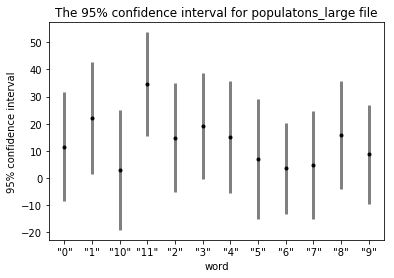

In [95]:
import matplotlib.pyplot as plt

means = list()
std = list()
names = list()
for i in range(len(dat)):
    means.append(dat[i][1][1])
    std.append(dat[i][1][2])
    names.append(dat[i][0])
    
means = np.array(means)
std  = 1.96*np.array(std)

plt.errorbar(np.arange(12), means, std, fmt='.k', ecolor='gray',lw=3)
ax = plt.gca()
ax.set_xticks(range(len(names)))
ax.set_xticklabels(names)
plt.title('The 95% confidence interval for populatons_large file')
plt.xlabel('word')
plt.ylabel('95% confidence interval')
plt.show()


## Problem 3:  Counting Triangles with PySpark

In [ ]:
# Q3-1

from pyspark import SparkConf, SparkContext
import sys

if len(sys.argv) != 3:
    print('Usage:' + sys.argv[0] + '<in><out>')
    sys.exit(1)
inputlocation = sys.argv[1]
outputlocation = sys.argv[2]
 
# set up configuration and jon context
conf = SparkConf().setAppName('Test')
sc = SparkContext(conf = conf)

# load the data
data = sc.textFile(inputlocation)
data = data.map(lambda line: line.split())

def pair(l):
    pa = [tuple(sorted((l[0],l[i],l[j]))) for i in range(1, len(l)) for j in range(i+1, len(l))]
    return(pa)


data_new = data.flatMap(lambda row: pair(row))
data_new1 = data_new.map(lambda ele: (ele, 1))
data_new2 = data_new1.reduceByKey(lambda x,y: x+y)
data_new3 = data_new2.filter(lambda x: x[1]>=2)
output = data_new3.map(lambda x: x[0])

output.saveAsTextFile(outputlocation)
sc.stop()

